# HeadMind Partners XAI Class - Resignation prediction

### Ariane Dalens 

<img src=https://mma.prnewswire.com/media/1715842/HeadMind_Partners_Logo.jpg width="500">

<img src=https://www.centralesupelec.fr/sites/all/themes/cs_theme/medias/common/images/intro/logo.png width="500">

*Context*

A company faces a large turnover rate and has difficulties to anticipate the resignations. The stakes are numerous : projects are delayed, excessive costs are incurred ... To overcome such a problem, the company decided to implement an AI approach to try to predict the resignations **within the 6 next months**. A confidence score would be really appreciated to estimate the risk of resignations for each employees.

*Dataset*

The HR dataset used for this course is generated from an existing HR dataset. The latter has been anonymized and then artificially generated using a *Variational Auto-Encoder*. Those generated data are gathered in a *pickle* file that will be later on loaded. This *pickle* file is composed of :
- **a pandas DataFrame X** including all the **HR features** needed to implement a ML Model
- **a numpy array Y** representing **the labels**:
    - 0 : the corresponding employee did not resign within the 6 next months
    - 1 : the corresponding employee did resign within the 6 next months


The labels are not well balanced ie there are far less resignated employees within the 6 next months. Decisions must be taken on this matter. On the other hands, many external factors influence the employees' decision which are not necesseraly in the HR dataset.

*Objectives*

- Preprocessing of the input data and HR data exploration
- ML model implementation
- Implement explainability of the predictions using SHAPASH
- Improve the first model considering the explainability outcomes


*Notebook by Rémi Grand and Vadim Becquet (Headmind Partners AI & Blockchain)*

## Import the recommended libraries

In [1]:
! pip install -r requirements.txt

You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
import pickle
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from category_encoders import OneHotEncoder, OrdinalEncoder
from IPython.display import display

plt.style.use('seaborn-whitegrid')
sns.set_theme()

## Load and explore the dataset

The dataset needs to be extracted from the pickle file previously mentionned. **The dataset does not contain missing values** to focus rather on the statistical exploration.

The dataset includes employees from 2016 to 2020. 

In [3]:
# Loading du dataset

PATH = "data/dataset_RH.pkl"

with open(PATH, 'rb') as read_file:
    X, Y = pickle.load(read_file)
X.head()

,Famille d'emploi,Dernière promotion (mois),Dernière augmentation (mois),Début de contrat (années),Ancienneté groupe (années),Etablissement,Âge (années),Parent,Niveau hiérarchique,Salaire (Euros),Statut marital,Véhicule,matricule
0,Production,8.510000,7.900000,0.910000,0.970000,27,30,1,1,3199,Marié(e),0,32
1,Production,35.119999,22.690001,14.830000,16.299999,7,45,1,2,3861,Marié(e),1,1890
2,Production,25.299999,22.139999,17.309999,17.790001,28,49,1,2,4324,PACS,1,1847
3,Production,5.240000,5.100000,1.020000,1.750000,27,24,0,1,2641,Célibataire,0,2619
4,Production,35.919998,22.840000,8.050000,9.000000,7,46,1,2,5072,Marié(e),1,1963


Question : Which features are categorical ? 

We see that the dataset contains **7 categorical features**: 
- Famille d'emploi
- Etablissement
- Parent
- Niveau hiérarchique
- Statut marital 
- Véhicule
- Matricule 

In [4]:
# How many samples do we have in our dataset ?

# Features distributions : Do you find any outliers ?

X.describe()

,Dernière promotion (mois),Dernière augmentation (mois),Début de contrat (années),Ancienneté groupe (années),Etablissement,Âge (années),Parent,Niveau hiérarchique,Salaire (Euros),Véhicule,matricule
count,23857.000000,23857.000000,23857.000000,23857.000000,23857.000000,23857.000000,23857.000000,23857.000000,23857.000000,23857.000000,23857.000000
mean,29.460739,7.934986,7.530322,11.632095,20.193947,41.767154,0.720711,1.554554,4168.404032,0.506853,1361.255858
std,25.497874,7.549982,5.985476,9.218618,9.295469,11.014444,0.448659,0.657887,1657.829824,0.500299,794.183153
min,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,1.000000,2134.000000,0.000000,0.000000
25%,10.590000,3.180000,2.300000,3.800000,11.000000,34.000000,0.000000,1.000000,3197.000000,0.000000,655.000000
50%,21.219999,5.880000,6.280000,9.870000,26.000000,41.000000,1.000000,1.000000,3629.000000,1.000000,1371.000000
75%,41.400002,10.340000,11.070000,16.320000,28.000000,49.000000,1.000000,2.000000,4511.000000,1.000000,2072.000000
max,152.970001,84.050003,33.119999,45.619999,36.000000,100.000000,1.000000,4.000000,18137.000000,2.000000,2675.000000


We have **23857** samples in the dataset.   
We see that that there is **no missing value** in the dataset.  
We find **few outliers** in the dataset, the data and distribution seems to have been cleaned beforehand (see below): 
- I can see one datapoint with Vehicule == 2
- The maximum age is 100 years old, which seems to be old for an employee

Overall there data where generated with a VAE, it is possible that these "high" values are due to the VAE, it can be considered as outliers.

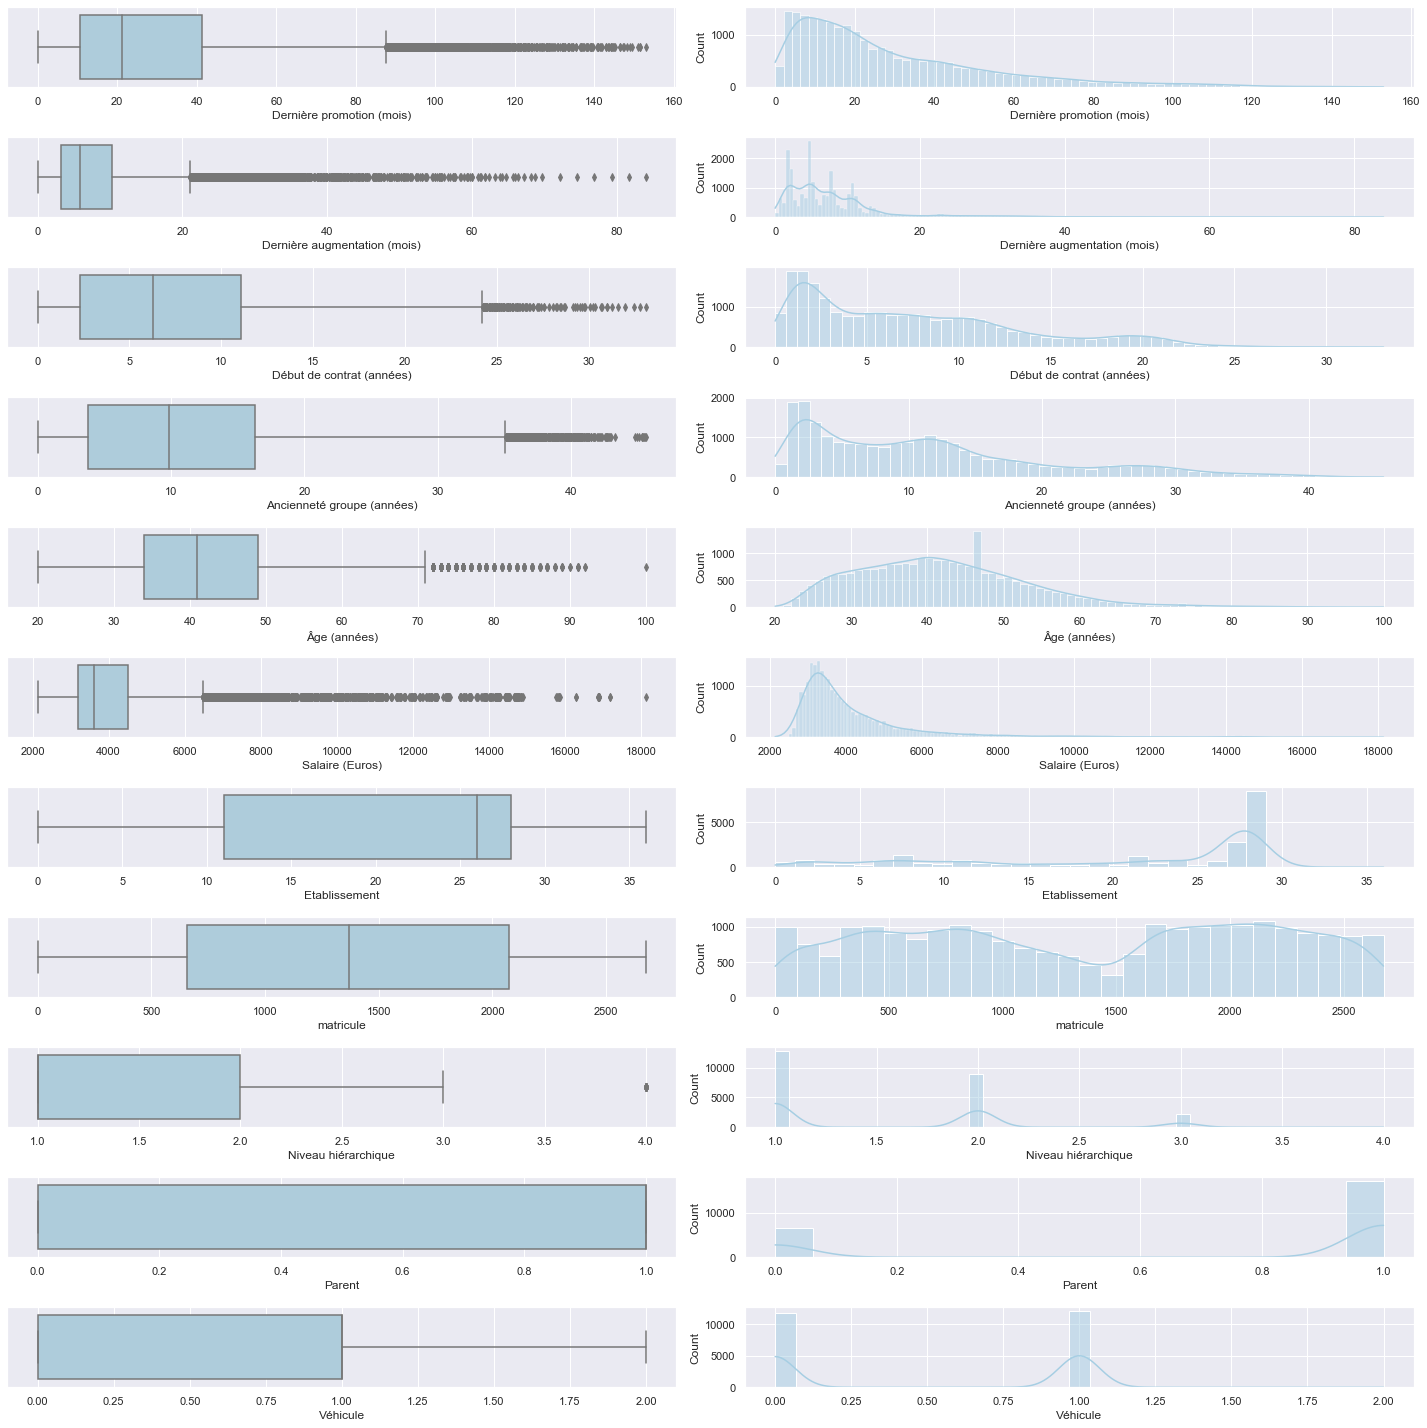

In [5]:
import seaborn as sns
sns.set(palette="Paired")
pastel_palette = {0: "C4", 1: "C2"}
bright_palette = {0: "C5", 1: "C3"}

cat_columns = ["Famille d'emploi", 'Etablissement', 'Statut marital','Niveau hiérarchique','Parent', 'matricule', 'Véhicule']
num_columns = ['Dernière promotion (mois)', 'Dernière augmentation (mois)', 'Début de contrat (années)',
'Ancienneté groupe (années)', 'Âge (années)', 'Salaire (Euros)']
num_col = num_columns + ['Etablissement', 'matricule', 'Niveau hiérarchique','Parent', 'Véhicule']

data = X.copy()[num_col]

fig, ax = plt.subplots(len(data.columns), 2, figsize = (20, 20))
for i in range(len(data.columns)):
    sns.boxplot(x= data[data.columns[i]], ax = ax[i,0])
    sns.histplot(data[data.columns[i]], ax = ax[i,1], kde=True)
plt.tight_layout()


Question: How many different employees are gathered in this dataset?

In [6]:
print(f' There are {len(X.matricule.unique())} unique employees in the dataset')

 There are 2676 unique employees in the dataset


Question: How many employees did resignate within the next six months in the dataset ? What is then the proportion of this label ?

In [7]:
# Add Y to X for the model
dataset = pd.concat([X, pd.Series(Y, name='resigned')], axis=1)

print(f' There are {len(dataset[dataset.resigned==1].matricule.unique())} unique employees who resigned in the dataset')
print(f' There are {len(dataset[dataset.resigned==1])} label resigned in the dataset out of {len(dataset)} samples (ratio : {len(dataset[dataset.resigned==1])/len(dataset)*100} %)')

 There are 408 unique employees who resigned in the dataset
 There are 755 label resigned in the dataset out of 23857 samples (ratio : 3.1646896089198138 %)


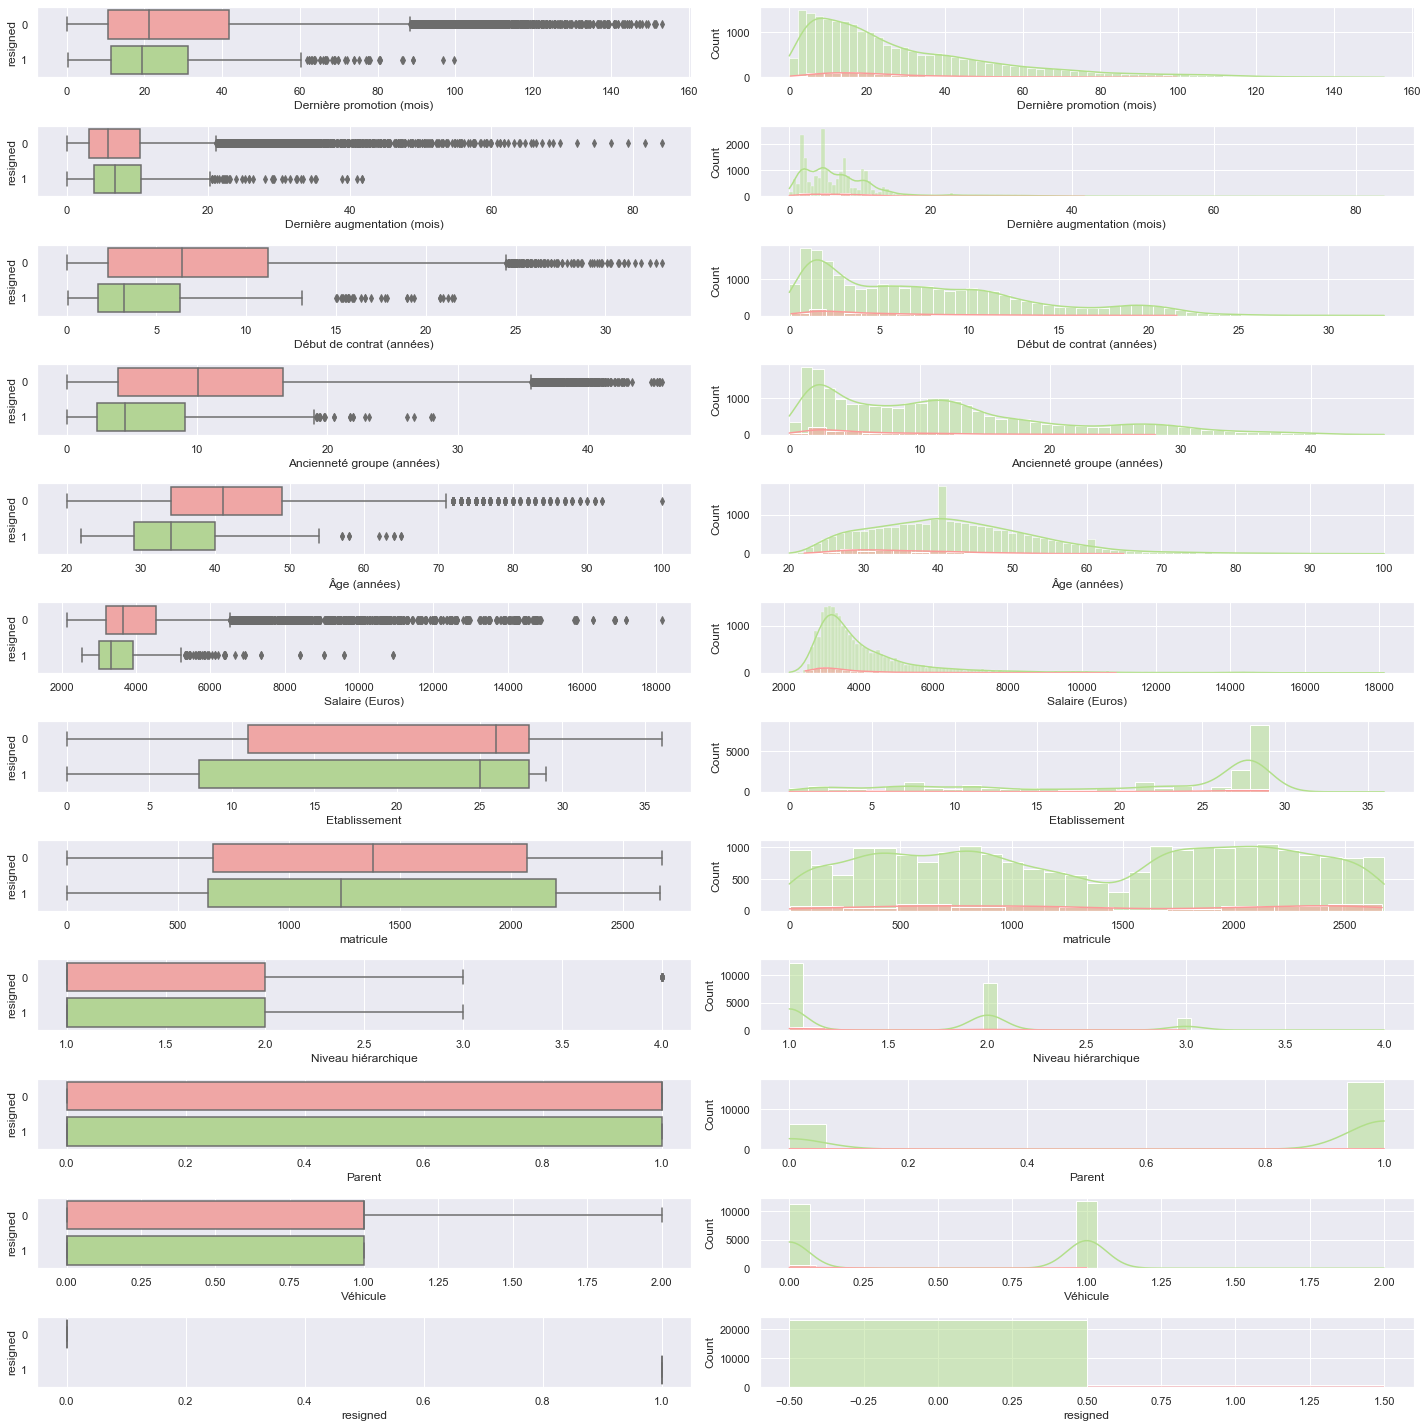

In [8]:
data = dataset.copy()
data = data[num_col + ['resigned']]

fig, ax = plt.subplots(len(data.columns), 2, figsize = (20, 20))
for i in range(len(data.columns)):
    sns.boxplot(y=data["resigned"], x=data[data.columns[i]], ax = ax[i,0], orient="h", palette=pastel_palette)
    sns.histplot(data[data.columns[i]].loc[data["resigned"]==0], ax = ax[i,1], kde=True, color="C2")
    sns.histplot(data[data.columns[i]].loc[data["resigned"]==1], ax = ax[i,1], kde=True, color="C4")
plt.tight_layout()


Employees who resigned seem to be younger than those who didn't....  
They tend to have a lower salary and they have been with the company for less time

Question: Consider a random employee who decided to resignate. Take a look at his evolution in the company from his hiring until his resignation

In [9]:
# HINTS
# idx_resignate = np.where(...)
# rand_idx = ... # Select a random resignation
# resignated_employee = ... # Get the matricule of the randomly picked employee

# evolution_employee = ... # Extract the subdataframe with the feature evolutions of the resignated employees

In [10]:
import random

idx_resignate = dataset[dataset.resigned==1].index
rand_idx = random.choice(idx_resignate)
resignated_employee = dataset.iloc[rand_idx]

evolution_employee = dataset[dataset.matricule==resignated_employee.matricule]

display(evolution_employee)

,Famille d'emploi,Dernière promotion (mois),Dernière augmentation (mois),Début de contrat (années),Ancienneté groupe (années),Etablissement,Âge (années),Parent,Niveau hiérarchique,Salaire (Euros),Statut marital,Véhicule,matricule,resigned
933,Support,4.080000,1.74,6.71,9.53,23,37,1,2,3969,Marié(e),1,2363,0
2308,Support,7.050000,4.73,7.00,9.63,23,38,1,2,3968,Marié(e),1,2363,0
3841,Support,9.930000,7.71,7.27,9.72,23,39,1,2,3968,Marié(e),1,2363,0
5886,Support,12.790000,10.69,7.52,9.79,22,40,1,2,3969,Marié(e),1,2363,1
7490,Support,16.219999,1.94,7.85,10.51,23,40,1,2,4066,Marié(e),1,2363,1


### Using seaborn to explore data 

As studied previously, the features are evolving for each employees in the time period 2016-2020. This evolution could be modeled as a time series experiment. In the first place, we will focus on classic ML models.

Correlation matrixes and features distributions according to the resignation decision are displayed using the *seaborn* library.

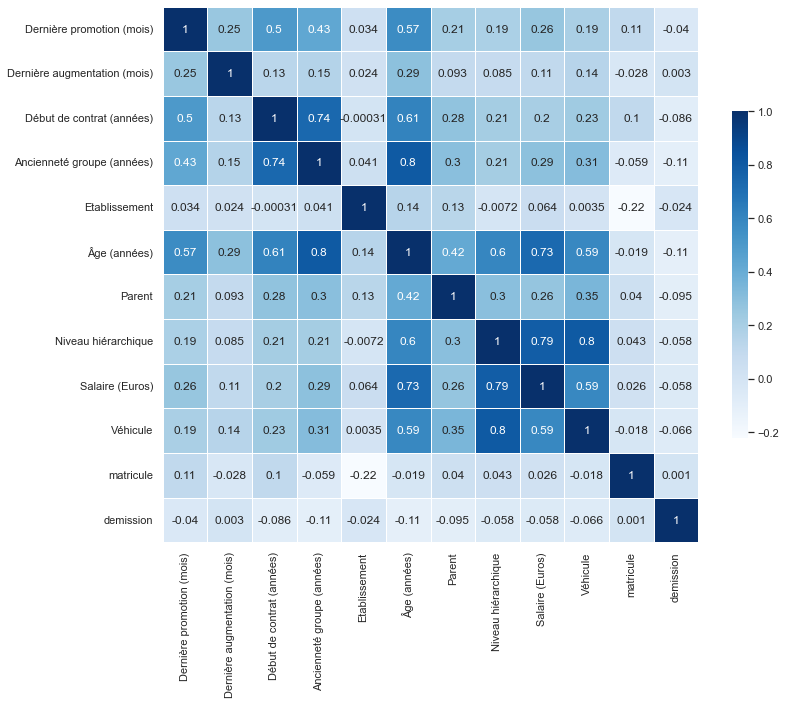

In [11]:
# Correlation matrix

df = X.copy()

# Add the label to the dataframe df to compute the correlation
df["demission"] = Y

corr = df.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr, cmap="Blues", annot=True, square=True, linewidths=.5, cbar_kws={"shrink": .5});

Question: What do you notice regarding the target feature 'demission', which is what we will be trying to predict?  
There is no obvious corrélation between the target feature and the features themselves.   
(Which is actually a good thing, we are not trying to predict something obvious ...)

Question: What interesting correlations do you notice (for instance with the feature 'Âge (années)' or 'Salaire') ?

The most interesting correlations are between the features:
- 'Âge (années)' and 'Salaire': older people have higher salaries
- 'Âge (années)' and 'Niveau hiérarchique': older people have higher hierarchies
- 'Niveau hiérarchique' and 'Vehicule': higher hierarchies are more likely to have a car
- 'Niveau hiérarchique' and 'Salaire': higher hierarchies are more likely to have a high salary 

These correlations are not highly interesting as they are not directly related to the target feature. Moreover there are kind of expected correlations between the features. 

In [12]:
df.columns

Index(['Famille d'emploi', 'Dernière promotion (mois)',
       'Dernière augmentation (mois)', 'Début de contrat (années)',
       'Ancienneté groupe (années)', 'Etablissement', 'Âge (années)', 'Parent',
       'Niveau hiérarchique', 'Salaire (Euros)', 'Statut marital', 'Véhicule',
       'matricule', 'demission'],
      dtype='object')

It can sometimes be useful to visualise the distribution of a particular set of features. First, we can try and visualise the age distribution for employees who resigned or didn't resign in the next 6 months. These distributions seem to indicate that the subgroup of employees who resigned are generally younger than the subgroup of employees who did not resign.

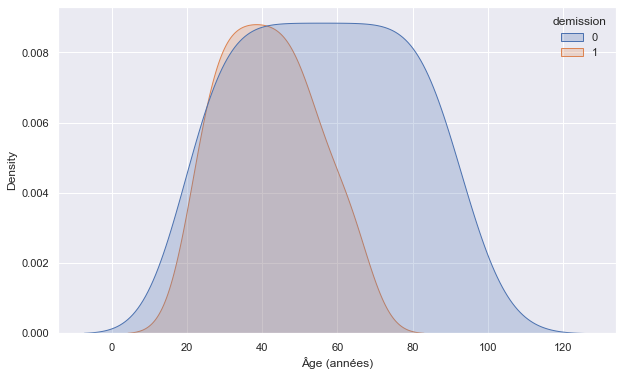

In [13]:
x,y = 'Âge (années)', 'demission'

plt.figure(figsize=(10,6))
sns.set_theme()
sns.kdeplot(data=df.groupby(x)[y].value_counts(normalize=True).mul(100), x=x, hue=y, fill=True);

Question: How do you interpret this visualisation?

Like I said before the employees who resigned seem to be younger on average than those who didn't.

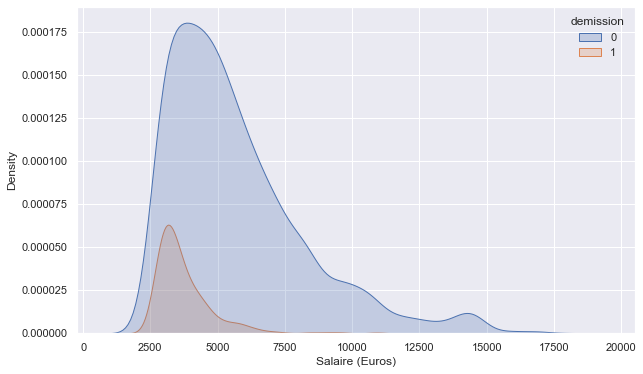

In [14]:
x,y = 'Salaire (Euros)', 'demission'

plt.figure(figsize=(10,6))
sns.set_theme()
sns.kdeplot(data=df.groupby(x)[y].value_counts(normalize=True).mul(100), x=x, hue=y, fill=True);

Question: How do you interpret this visualisation?

Similarly, salaries are lower for people who resigned.

Similarly in this 2D plot, we can visualise the combination of salary and age with respect to the target variable 'demission'. The subgroup of employees who resigned have a generally smaller salary in addition to being younger.

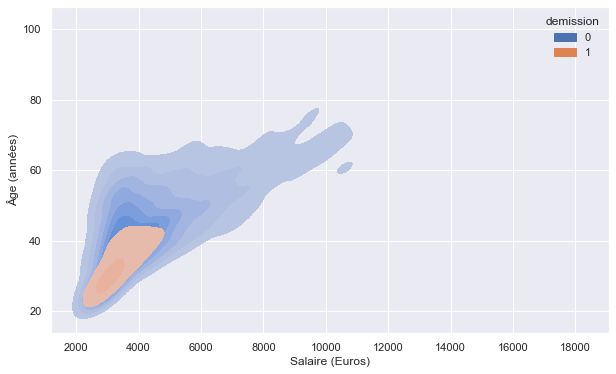

In [15]:
plt.figure(figsize=(10,6))
sns.set_theme()
sns.kdeplot(data=df, x="Salaire (Euros)", y="Âge (années)", hue="demission", fill=True);

Question: How do you interpret this visualisation?

The subgroup (in orange) of employees who resigned have a generally smaller salary in addition to being younger.

Question : Do the parents tend to resignate more in the input dataset ?

No as 97.9% of the parents did not resignate within the next 6 months. Whereas 94% of the non-parents did not resignate within the next 6 months. 

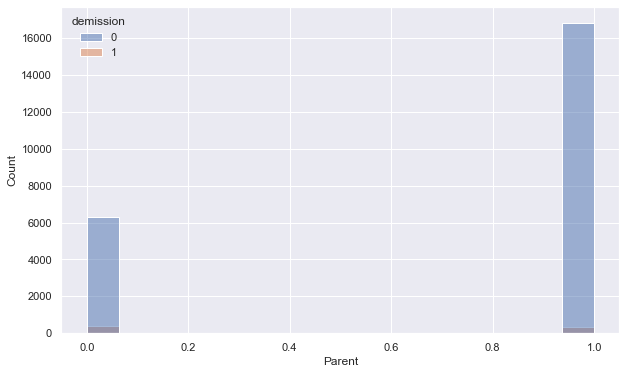

In [16]:
x, y = 'Parent', 'demission'

plt.figure(figsize=(10, 6))
sns.set_theme()
sns.histplot(data=df, hue=y, x=x, fill=True);

Question : How many months after their last promotion are the employees the most likely to leave the company according to the input data ?


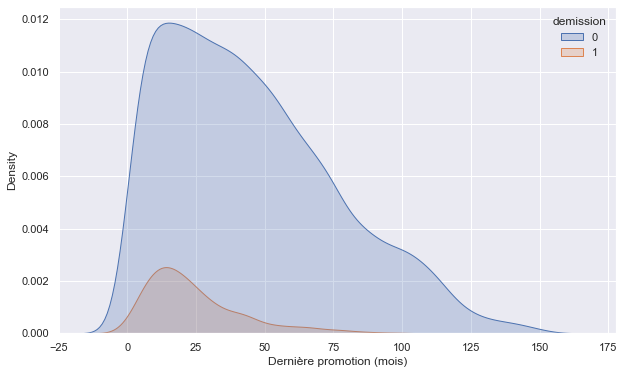

In [17]:
x,y = 'Dernière promotion (mois)', 'demission'

plt.figure(figsize=(10,6))
sns.set_theme()
sns.kdeplot(data=df.groupby(x)[y].value_counts(normalize=True).mul(100), x=x, hue=y, fill=True);

The average resignation rate is estimated between 10 and 15 months without a new promotion.

### Encode the dataset

The preliminar data exploration performed helps us discovering all the features in the dataset, their distributions and correlations. The categorical features have also been targeted. The *category_encoders* library will then be called to transform our previous dataset for a future ML implementation. This library is compatible with the *SHAPASH* library for explainability.

Two category_encoders are needed for our transformation :
- <a href="https://contrib.scikit-learn.org/category_encoders/onehot.html">OneHotEncoder</a>
- <a href="https://contrib.scikit-learn.org/category_encoders/ordinal.html">OrdinalEncoder</a>

In [18]:
# Pick the right features to encode
ONEHOT_ENC_FT = ["Famille d'emploi", "Etablissement", "Statut marital"]
ORDINAL_ENCODER = ["Niveau hiérarchique"]

onehot_encoder = OneHotEncoder(cols=ONEHOT_ENC_FT)
ordinal_encoder = OrdinalEncoder(cols=ORDINAL_ENCODER)

################
# Fit_transform
X_enc = onehot_encoder.fit_transform(X)
X_enc = ordinal_encoder.fit_transform(X_enc)

################
display(X_enc.head())
encoders = [onehot_encoder, ordinal_encoder]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Famille d'emploi_1,Famille d'emploi_2,Famille d'emploi_3,Famille d'emploi_4,Famille d'emploi_5,Famille d'emploi_6,Famille d'emploi_7,Famille d'emploi_8,Dernière promotion (mois),Dernière augmentation (mois),...,Statut marital_2,Statut marital_3,Statut marital_4,Statut marital_5,Statut marital_6,Statut marital_7,Statut marital_8,Statut marital_9,Véhicule,matricule
0,1,0,0,0,0,0,0,0,8.510000,7.900000,...,0,0,0,0,0,0,0,0,0,32
1,1,0,0,0,0,0,0,0,35.119999,22.690001,...,0,0,0,0,0,0,0,0,1,1890
2,1,0,0,0,0,0,0,0,25.299999,22.139999,...,1,0,0,0,0,0,0,0,1,1847
3,1,0,0,0,0,0,0,0,5.240000,5.100000,...,0,1,0,0,0,0,0,0,0,2619
4,1,0,0,0,0,0,0,0,35.919998,22.840000,...,0,0,0,0,0,0,0,0,1,1963


### PCA

Dimensionality reduction is a powerful tool in machine learning to help Data Scientists visualise high-dimensional data in a 2D space. Once the reduction applied, the computational time is also considerably reduced. 

Data Scientists need to understand the trade off between information loss and simplicity of visualisation.

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler1 = StandardScaler()
x_pca = scaler1.fit_transform(X_enc)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x_pca)
pca_df = pd.DataFrame(data = principal_components
             , columns = ['principal component 1', 'principal component 2'])
pca_df['demission'] = Y
pca_df.head()

,principal component 1,principal component 2,demission
0,-1.812296,-0.652484,0
1,1.788403,-1.561927,0
2,1.966233,-0.562892,0
3,-3.533552,0.978090,1
4,1.538062,-0.817117,0


[]

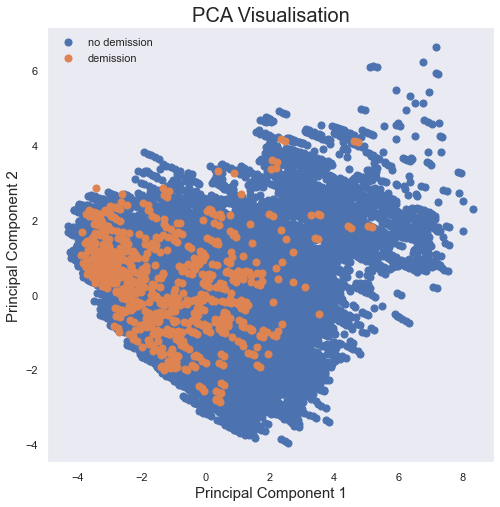

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA Visualisation', fontsize = 20)
demission = [0, 1]
color = sns.color_palette().as_hex()

for dem, color in zip(demission,color):
    indicesToKeep = pca_df["demission"] == dem
    ax.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(['no demission', 'demission'])
ax.grid()
ax.plot()

Question: How do you interpret the results of the PCA? Is this PCA with 2 components reliable for a ML implementation ?

It is still not linearly separable. Therefore not so reliable for an ML implementation.

## ML implementation

The dataframe is now freshly encoded and ready to be fed to a machine learning model.

Nevertheless, a smart train/test split is required. As mentionned in the exploration part, around 2500 employees are gathered in the complete 23000-shaped dataset. A naive train/test split on the encoded dataframe with *scikit-learn* would definitely place the same employees (at different time steps) in the train and in the test splits. Such a split would bias the training of a ML model.

The train/test split needs therefore to be executed on the **matricules** to bring together all the time steps for each employees in the same subdataset (train or test).

### Train/test split

In [21]:
test_size = 0.2
random_state = 420
matricules = X_enc["matricule"].unique()

mat_train, mat_test = train_test_split(
    matricules, test_size=test_size, random_state=random_state)
idx_mat_train = X_enc[X_enc["matricule"].isin(mat_train)].index
idx_mat_test = X_enc[X_enc["matricule"].isin(mat_test)].index

X_train = X_enc.loc[idx_mat_train].reset_index(drop=True)
X_test = X_enc.loc[idx_mat_test].reset_index(drop=True)

Y_train = Y[idx_mat_train]
Y_test = Y[idx_mat_test]

# Assert distribution is the same

_, dist_init = np.unique(Y, return_counts=True)
_, dist_train = np.unique(Y_train, return_counts=True)
_, dist_test = np.unique(Y_test, return_counts=True)

print("Label distribution in the global dataset : {:2f} %".format(dist_init[1]/dist_init[0]*100))
print("Label distribution in the train dataset : {:2f} %".format(dist_train[1]/dist_train[0]*100))
print("Label distribution in the test dataset : {:2f} %".format(dist_test[1]/dist_test[0]*100))

Label distribution in the global dataset : 3.268115 %
Label distribution in the train dataset : 3.206824 %
Label distribution in the test dataset : 3.516052 %


In [22]:
# Remove "matricule" feature

X_train.drop(columns=["matricule"], inplace=True)
X_test.drop(columns=["matricule"], inplace=True)

### Training with optuna

We use Optuna to run hyperparameters optimizations for the model chosen. To correctly use Optuna you need :

- A ML model
- an *objective* function with *trial* as argument.
    - Specify the hyperparameters to optimize (xgb_params for the XGBoost classifier)
    - Returns the score of the new training. This score needs either to be minimized (loss) or maximized (metric)

You'll find below an example for the Optuna implementation.

**A sample weight is recommended when implementing a RandomForestClassifier.** When it comes to XGBoost, it will not be necessary (because corrective weights are assigned during the training process).

The score chosen in the hyperparameters research is decisive. Please keep in mind that we are dealing with classification.

#### Random Forest

The Optuna objective function and the study to optimize the hyperparameters are shown in the couple cells below. As mentioned, a sample weight is computed to weight the loss function during the training.

In [23]:
# TO COMPLETE

sample_weight = compute_sample_weight(class_weight="balanced", y=Y_train)
display(sample_weight)

array([ 0.51603412,  0.51603412, 16.09175084, ...,  0.51603412,
        0.51603412,  0.51603412])

In [24]:
def objective_rf(trial):
    rf_params = {
            # Parameter space definition
            # 'n_estimators' : trial.suggest_int('n_estimators', ..., ...),
            # ...
                'n_estimators' : trial.suggest_int('n_estimators', 10, 300),
                'max_depth' : trial.suggest_int('max_depth', 1, 10),
                'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 20),
                'min_samples_split' : trial.suggest_int('min_samples_split', 2, 20),
                'max_features' : trial.suggest_uniform('max_features', 0.1, 1.0),
                'bootstrap' : trial.suggest_categorical('bootstrap', [True, False]),
                'criterion' : trial.suggest_categorical('criterion', ['gini', 'entropy']),
                'class_weight' : trial.suggest_categorical('class_weight', ['balanced', None]),
                'n_jobs' : trial.suggest_int('n_jobs', 1, 4),
            }

    rf_classifier = RandomForestClassifier(random_state=42)
    rf_classifier.set_params(**rf_params)
    rf_classifier.fit(X_train, Y_train, sample_weight=sample_weight)
    Y_pred = rf_classifier.predict(X_test)
    score=roc_auc_score(Y_test, Y_pred)
    return score

In [25]:
study = optuna.create_study(direction="maximize")
full_objective = lambda trial: objective_rf(trial)
study.optimize(full_objective, n_trials=60, timeout=600)
rf_params = study.best_trial.params

[I 2022-04-04 19:41:51,705] A new study created in memory with name: no-name-f3c5fe40-c1b0-4527-838d-82352c4dcf9b
[I 2022-04-04 19:42:06,531] Trial 0 finished with value: 0.6588116963887257 and parameters: {'n_estimators': 249, 'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 7, 'max_features': 0.934988687602913, 'bootstrap': True, 'criterion': 'gini', 'class_weight': None, 'n_jobs': 1}. Best is trial 0 with value: 0.6588116963887257.
[I 2022-04-04 19:42:14,360] Trial 1 finished with value: 0.6798597160409594 and parameters: {'n_estimators': 276, 'max_depth': 3, 'min_samples_leaf': 11, 'min_samples_split': 13, 'max_features': 0.6939736945050071, 'bootstrap': False, 'criterion': 'gini', 'class_weight': None, 'n_jobs': 1}. Best is trial 1 with value: 0.6798597160409594.
[I 2022-04-04 19:42:16,152] Trial 2 finished with value: 0.5786455585111072 and parameters: {'n_estimators': 85, 'max_depth': 8, 'min_samples_leaf': 14, 'min_samples_split': 6, 'max_features': 0.457933858218996

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


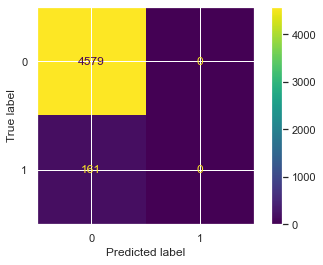

In [26]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.set_params(**rf_params)
rf_clf.fit(X_train, Y_train, sample_weight=None)
plot_confusion_matrix(rf_clf, X_test, Y_test);

Question : Comment the confusion matrix for the Random Forest Classifier. How many false positives ?

There is no false positive as the classifiers never predicts the resigned label

Question : Compute the precision and recall for the resignation class (1).

In [27]:
# Compute precision and recall for class 1 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

Y_pred = rf_clf.predict(X_test)

precision = precision_score(Y_test, Y_pred, pos_label=1, zero_division=0)
recall = recall_score(Y_test, Y_pred, pos_label=1)

print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.0
Recall: 0.0


#### XGBoost

Let's use XGBoost to improve the RandomForest performances. The boosting method automatically assigns corrective weights to mispredicted data samples. 

In [28]:
def objective(trial):
    xgb_params = {
        # Parameter space definition
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'learning_rate': trial.suggest_discrete_uniform('learning_rate', 0.01, 0.3, 0.01),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 100),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.5, 1.0, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.5, 1.0, 0.1),
        'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.5, 1.0, 0.1),
        'gamma': trial.suggest_discrete_uniform('gamma', 0.0, 1.0, 0.1),
        'reg_lambda': trial.suggest_int('reg_lambda', 1, 100),
    }

    xgb_classifier = XGBClassifier(
        objective='binary:logistic', eval_metric='auc', use_label_encoder=False)
    xgb_classifier.set_params(**xgb_params)
    xgb_classifier.fit(X_train, Y_train, sample_weight=None)
    Y_pred = xgb_classifier.predict(X_test)

    score = roc_auc_score(Y_test, Y_pred)
    return score

study = optuna.create_study(direction="maximize")
def full_objective(trial): return objective(trial)


study.optimize(full_objective, n_trials=60, timeout=600)
xgb_params = study.best_trial.params

[I 2022-04-04 19:46:28,891] A new study created in memory with name: no-name-0343308f-35a3-47d7-9304-493382aba6bb
[I 2022-04-04 19:46:31,794] Trial 0 finished with value: 0.6636603234588365 and parameters: {'n_estimators': 58, 'max_depth': 8, 'min_child_weight': 3, 'learning_rate': 0.06999999999999999, 'scale_pos_weight': 94, 'subsample': 0.7, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'gamma': 1.0, 'reg_lambda': 96}. Best is trial 0 with value: 0.6636603234588365.
[I 2022-04-04 19:46:36,059] Trial 1 finished with value: 0.5838956944951228 and parameters: {'n_estimators': 99, 'max_depth': 8, 'min_child_weight': 5, 'learning_rate': 0.22, 'scale_pos_weight': 35, 'subsample': 1.0, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'gamma': 0.30000000000000004, 'reg_lambda': 32}. Best is trial 0 with value: 0.6636603234588365.
[I 2022-04-04 19:46:38,837] Trial 2 finished with value: 0.6634032763669954 and parameters: {'n_estimators': 73, 'max_depth': 5, 'min_child_weight': 1, 'lear

In [29]:
xgb_params

{'n_estimators': 55,
 'max_depth': 7,
 'min_child_weight': 6,
 'learning_rate': 0.02,
 'scale_pos_weight': 38,
 'subsample': 0.8,
 'colsample_bytree': 1.0,
 'colsample_bylevel': 1.0,
 'gamma': 0.30000000000000004,
 'reg_lambda': 83}

Once the hyperparameter search is over, train a classifier with the best parameters on the complete dataset.

In [30]:
clf = XGBClassifier(objective="binary:logistic", use_label_encoder=False)
clf.set_params(**xgb_params)
clf.fit(X_enc.drop(columns=["matricule"]), Y, sample_weight=None)

[19:49:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=1.0,
              gamma=0.30000000000000004, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=7, min_child_weight=6, missing=nan,
              monotone_constraints='()', n_estimators=55, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=83,
              scale_pos_weight=38, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


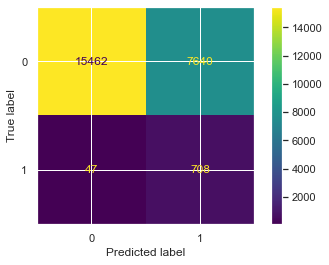

In [31]:
plot_confusion_matrix(clf, X_enc.drop(columns=['matricule']), Y)

Question : Compare this new confusion matrix to the RF one. Give the precision and recall for the class 1.

In [32]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

Y_pred = clf.predict(X_test)

precision = precision_score(Y_test, Y_pred, pos_label=1, zero_division=0)
recall = recall_score(Y_test, Y_pred, pos_label=1)
f1 = f1_score(Y_test, Y_pred, pos_label=1)
roc_score = roc_auc_score(Y_test, Y_pred)

print(f"Precision: {precision*100} %")
print(f"Recall: {recall*100} %")
print(f"F1-score: {f1*100} %")
print(f"ROC Score: {roc_score*100} %")

Precision: 10.165016501650165 %
Recall: 95.65217391304348 %
F1-score: 18.37708830548926 %
ROC Score: 82.96476352345775 %


This classifier is far better than the RandomForest one. Indeed, the precision is higher and the recall is higher. (Higher than 0 is not really difficult though ... 😉) 

Our model has trained on the full dataset. Let's try to understand how the classification was performed, which features are the most relevant, how they contribute to the final decision ...

## Explainability with Shapley values

<a href="https://christophm.github.io/interpretable-ml-book/shapley.html">Shapley values</a> are common coefficients to quantify the contributions of each features in the predictions of the model. Theoretically, *coalitions* are made to observe the influence of a selected feature in the prediction. The contribution is computed by comparing the predictions with and without this feature.

The computation can take a while, especially on large dataset. The contribution computation is thus often made on random subsets.

In [33]:
from shapash.explainer.smart_explainer import SmartExplainer

input_ex = X_enc.drop(columns=["matricule"])

xpl = SmartExplainer(label_dict={0: 'Pas de démission', 1:'Démission'})
xpl.compile(
        x=input_ex,
        preprocessing=encoders,
        model=clf
        )

Backend: Shap TreeExplainer


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



In [34]:
xpl.plot.contribution_plot(col="Âge (années)")

Question : Compare the contributions for young and old employees. Did you expect such a difference ? Why ?

We see that younger employees have a higher contribution to the prediction. Indeed, the young employees are more likely to resign.

Question : A colored scale is displayed in the right part of the graph, representing a "Predicted probability" for demission. How does the predicted probability evolve with the SHAP contribution ? What do you conclude about the importance of the "Âge (années)" feature ?

The color is clearly separated by age, meaning that this feature does contribute to the final prediction. 

Indeed, the probability of demission is higher for young employees. For older employees (>50 ans), the SHAP contribution is < -1 which tends to indicate a high probability for them to remain in the company.

Age is therefore a useful feature to understand the probability of demission.

In [35]:
xpl.plot.contribution_plot(col="Ancienneté groupe (années)")

Question : Explain the "Ancienneté groupe (années)" contribution plot. How is it correlated with the "Âge (années)" contribution plot?

Same for seniority in the company it a good indicator of the probability of demission, kind of in the same way as the age contribution plot.   
In the first few months of seniority, the probability of resignation is lower, then higher between 2 and 10 months and after one year the contribution is negative. Beyond 24 months, the contribution is strongly negative, the model will tend to predict that employees will not leave the company 

Question : What can you infer about the feature importance ?

The absolute contribution values are quite high, so we can infer that the feature is important. 

In [36]:
xpl.plot.contribution_plot(col="Statut marital")

Question : What do you notice about the median contributions of all the values for the "Statut marital" feature ? 

The median contribution of all the values for "Statut marital" is negative. It is not a good indicator therefore for the demission, moreover the absolute value si often low (<0.1)

Question : Take a look at the "Célibataire" and "Marié(e)" contributions. What do you think ? What do you conclude about the relevance of this feature during the training process ?

This feature doesn't seem to have a great impact on the model, the distribution of the SHAP values is quite similar for "Célibataire" et "Marié(e)"

In [37]:
xpl.plot.contribution_plot(col="Parent")

Question : Explain the contribution plot. Does this contribution plot makes sense ? (in your opinion and compared to the input data ?)

According to this graph, the "Parent" feature is the most important one. Indeed, the SHAP contribution are positive for this feature if the employee is not a parent. It is coherent with the data (as seen before) however this link was not very strong, the absolute value of the SHAP contribution is quite low (< 0.2).

In [38]:
xpl.plot.features_importance()

Question : The feature importance is finally displayed. How do you build such a graph having computed the contributions of every feature independantly ?

According to the [documentation](https://shapash.readthedocs.io/en/latest/tutorials/tuto-plot03-features-importance.html), the feature importance is computed by computing the Shapley values of the model.

The method features_importance displays a bar chart representing the **sum of absolute contribution values of each feature**.

This method also makes it possible to represent this sum calculated on a subset and to compare it with the total population

## Feature selection for model's improvements

Now that the feature importances are displayed, one can select the decisive ones, study their contributions to the predictions of the model. 

We propose to select features according to their contribution and feature importance plots, in order to improve the baseline of the previous XGBoost model.

**Previous baseline : AUC_ROC_CURVE = 0.701**

Question : According to the previous contribution plots, which features are to be removed to try to improve the baseline ? (other contribution plots can be displayed)

In [39]:
with open(PATH, 'rb') as read_file:
    X, Y = pickle.load(read_file)
display(X.head())
columns = ["Famille d'emploi", 'Dernière promotion (mois)',
       'Dernière augmentation (mois)', 'Début de contrat (années)',
       'Ancienneté groupe (années)', 'Etablissement', 'Âge (années)', 'Parent',
       'Niveau hiérarchique', 'Salaire (Euros)', 'Statut marital', 'Véhicule',
       'matricule', 'demission']

selected_columns = ['Ancienneté groupe (années)','Âge (années)','Dernière promotion (mois)',
'Parent', 'Salaire (Euros)', "Etablissement"]

selected_columns.append('matricule')
X = X[selected_columns]
display(X.head())

,Famille d'emploi,Dernière promotion (mois),Dernière augmentation (mois),Début de contrat (années),Ancienneté groupe (années),Etablissement,Âge (années),Parent,Niveau hiérarchique,Salaire (Euros),Statut marital,Véhicule,matricule
0,Production,8.510000,7.900000,0.910000,0.970000,27,30,1,1,3199,Marié(e),0,32
1,Production,35.119999,22.690001,14.830000,16.299999,7,45,1,2,3861,Marié(e),1,1890
2,Production,25.299999,22.139999,17.309999,17.790001,28,49,1,2,4324,PACS,1,1847
3,Production,5.240000,5.100000,1.020000,1.750000,27,24,0,1,2641,Célibataire,0,2619
4,Production,35.919998,22.840000,8.050000,9.000000,7,46,1,2,5072,Marié(e),1,1963


,Ancienneté groupe (années),Âge (années),Dernière promotion (mois),Parent,Salaire (Euros),Etablissement,matricule
0,0.970000,30,8.510000,1,3199,27,32
1,16.299999,45,35.119999,1,3861,7,1890
2,17.790001,49,25.299999,1,4324,28,1847
3,1.750000,24,5.240000,0,2641,27,2619
4,9.000000,46,35.919998,1,5072,7,1963


In [40]:
from category_encoders import OneHotEncoder, OrdinalEncoder as OrdinalEncoder_ce

ONEHOT_ENC_FT = ["Etablissement"]

onehot_encoder = OneHotEncoder(cols=ONEHOT_ENC_FT).fit(X)
X_enc = onehot_encoder.transform(X)

encoders = [onehot_encoder]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [41]:
# Train, test par matricule
test_size = 0.2
matricules = X_enc["matricule"].unique()

mat_train, mat_test = train_test_split(matricules, test_size=0.2, random_state=420)
idx_mat_train = X_enc[X_enc["matricule"].isin(mat_train)].index
idx_mat_test = X_enc[X_enc["matricule"].isin(mat_test)].index

X_train = X_enc.loc[idx_mat_train].reset_index(drop=True)
X_test = X_enc.loc[idx_mat_test].reset_index(drop=True)

Y_train = Y[idx_mat_train]
Y_test = Y[idx_mat_test]

# Assert distribution is the same

_, dist_init = np.unique(Y, return_counts=True)
_, dist_train = np.unique(Y_train, return_counts=True)
_, dist_test = np.unique(Y_test, return_counts=True)

print(dist_init[1]/dist_init[0])
print(dist_train[1]/dist_train[0])
print(dist_test[1]/dist_test[0])

0.03268115314691369
0.03206823948604438
0.035160515396374756


In [42]:
# Remove "matricule" feature

X_train.drop(columns=["matricule"], inplace=True)
X_test.drop(columns=["matricule"], inplace=True)

In [43]:
def objective(trial):
    xgb_params = {
            # Parameter space definition
            'n_estimators' : trial.suggest_int('n_estimators', 60, 100),
            'max_depth' : trial.suggest_int('max_depth', 5, 10),
            'min_child_weight' : trial.suggest_int('min_child_weight', 1, 10),
            'learning_rate' : trial.suggest_discrete_uniform('learning_rate', 0.01, 0.3, 0.01),
            'scale_pos_weight' : trial.suggest_int('scale_pos_weight', 1, 100),
            'subsample' : trial.suggest_discrete_uniform('subsample', 0.5, 1.0, 0.1),
            'colsample_bytree' : trial.suggest_discrete_uniform('colsample_bytree', 0.5, 1.0, 0.1),
            'colsample_bylevel' : trial.suggest_discrete_uniform('colsample_bylevel', 0.5, 1.0, 0.1),
            'gamma': trial.suggest_discrete_uniform('gamma', 0.0, 1.0, 0.1),
            'reg_lambda' : trial.suggest_int('reg_lambda', 1, 100),
        }

    xgb_classifier = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
    xgb_classifier.set_params(**xgb_params)
    xgb_classifier.fit(X_train, Y_train, sample_weight=None)
    Y_pred = xgb_classifier.predict(X_test)
    #y_pred = xgb_classifier.predict_proba(X_test)[:,1]
    #loss = log_loss(Y_test, y_pred)
    #return loss
    score=roc_auc_score(Y_test, Y_pred)
    return score

In [44]:
study = optuna.create_study(direction="maximize")
full_objective = lambda trial: objective(trial)
study.optimize(full_objective, n_trials=150, timeout=600)
xgb_params = study.best_trial.params

[I 2022-04-04 19:49:49,829] A new study created in memory with name: no-name-b3ac810b-acfe-4849-9f94-ee5b82db5106
[I 2022-04-04 19:49:54,870] Trial 0 finished with value: 0.6145371999365182 and parameters: {'n_estimators': 88, 'max_depth': 9, 'min_child_weight': 7, 'learning_rate': 0.27, 'scale_pos_weight': 82, 'subsample': 0.7, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8, 'gamma': 0.7000000000000001, 'reg_lambda': 46}. Best is trial 0 with value: 0.6145371999365182.
[I 2022-04-04 19:49:56,722] Trial 1 finished with value: 0.6491768389040433 and parameters: {'n_estimators': 79, 'max_depth': 6, 'min_child_weight': 2, 'learning_rate': 0.29000000000000004, 'scale_pos_weight': 46, 'subsample': 0.7, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.8, 'gamma': 0.9, 'reg_lambda': 89}. Best is trial 1 with value: 0.6491768389040433.
[I 2022-04-04 19:49:58,600] Trial 2 finished with value: 0.5940989041248258 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_child_weight': 8, 'lear

[19:59:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



Precision: 9.12721049629207 %
Recall: 99.37888198757764 %
F1-score: 16.718913270637408 %
ROC Score: 82.29481334583075 %


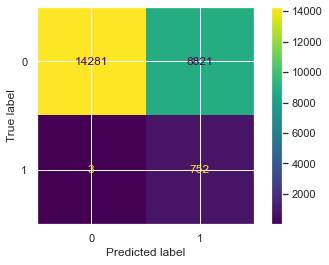

In [45]:
clf = XGBClassifier(objective="binary:logistic", use_label_encoder=False)
clf.set_params(**xgb_params)
clf.fit(X_enc.drop(columns=["matricule"]), Y, sample_weight=None)

plot_confusion_matrix(clf, X_enc.drop(columns=['matricule']), Y)

# Compute precision and recall for class 1 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

Y_pred = clf.predict(X_test)

precision = precision_score(Y_test, Y_pred, pos_label=1, zero_division=0)
recall = recall_score(Y_test, Y_pred, pos_label=1)
f1 = f1_score(Y_test, Y_pred, pos_label=1)
roc_score = roc_auc_score(Y_test, Y_pred)

print(f"Precision: {precision*100} %")
print(f"Recall: {recall*100} %")
print(f"F1-score: {f1*100} %")
print(f"ROC Score: {roc_score*100} %")

Question : Dit it improve the previous score compared to the baseline ?

Yes it did our ROC score is now 0.82 which is 13pts better than the previous baseline. On all accounts it is a good improvement (f1-score, recall, precision).
Selecting the right features thanks to XAI allowed us to have a better score and better model.

If not, consider other features to remove, or try to consider the correlations between the input features to avoid redundancy during the training process...